In [5]:
import pandas as pd

df = pd.read_csv(
    "MachineLearningRating_v3.txt", sep='|',
    parse_dates=["TransactionMonth", "VehicleIntroDate"],
    dtype={'CapitalOutstanding': str, 'CrossBorder': str}
)
print("Rows, Columns:", df.shape)
display(df.head(3))


C:\Users\btulu\AppData\Local\Temp\ipykernel_38232\1042072634.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


Rows, Columns: (1000098, 52)


UnderwrittenCoverID  PolicyID TransactionMonth  IsVATRegistered  \
0               145249     12827       2015-03-01             True   
1               145249     12827       2015-05-01             True   
2               145249     12827       2015-07-01             True   

  Citizenship          LegalType Title Language                 Bank  \
0              Close Corporation    Mr  English  First National Bank   
1              Close Corporation    Mr  English  First National Bank   
2              Close Corporation    Mr  English  First National Bank   

       AccountType  ...         ExcessSelected CoverCategory   CoverType  \
0  Current account  ...  Mobility - Windscreen    Windscreen  Windscreen   
1  Current account  ...  Mobility - Windscreen    Windscreen  Windscreen   
2  Current account  ...  Mobility - Windscreen    Windscreen  Windscreen   

             CoverGroup              Section                          Product  \
0  Comprehensive - Taxi  Motor Comprehensive  Mobility Metered Taxis: Monthly   
1  Comprehensive - Taxi  Motor Comprehensive  Mobility Metered Taxis: Monthly   
2  Comprehensive - Taxi  Motor Comprehensive  Mobility Metered Taxis: Monthly   

  StatutoryClass StatutoryRiskType  TotalPremium TotalClaims  
0     Commercial     IFRS Constant     21.929825         0.0  
1     Commercial     IFRS Constant     21.929825         0.0  
2     Commercial     IFRS Constant      0.000000         0.0  

[3 rows x 52 columns]

In [6]:
missing = df.isnull().sum().sort_values(ascending=False)
display(missing.head(10))

# Drop columns with >99% missingness
threshold = int(df.shape[0] * 0.99)
high_missing_cols = missing[missing > threshold].index.tolist()
print("Columns >99% missing:", high_missing_cols)
df.drop(columns=high_missing_cols, inplace=True)
print("After drop:", df.shape)


NumberOfVehiclesInFleet    1000098
CrossBorder                 999400
CustomValueEstimate         779642
Rebuilt                     641901
Converted                   641901
WrittenOff                  641901
NewVehicle                  153295
Bank                        145961
AccountType                  40232
Gender                        9536
dtype: int64

Columns >99% missing: ['NumberOfVehiclesInFleet', 'CrossBorder']
After drop: (1000098, 50)


In [7]:
print("Before deduplication:", len(df))
df = df.drop_duplicates()
print("After deduplication:", len(df))

# Fill binary flags
for col in ["Rebuilt", "Converted", "WrittenOff", "NewVehicle"]:
    df[col] = df[col].fillna("No")

# Median impute numerics
for col in ["mmcode", "Cylinders", "cubiccapacity", "kilowatts", "NumberOfDoors"]:
    df[col] = df[col].fillna(df[col].median())
df["CustomValueEstimate"] = df["CustomValueEstimate"].fillna(0)

# Mode impute categoricals
for col in ["Bank", "AccountType", "MaritalStatus", "Gender", "VehicleType", "make", "Model", "bodytype"]:
    df[col] = df[col].fillna("Unknown")

# CapitalOutstanding fix
df["CapitalOutstanding"] = (
    df["CapitalOutstanding"].fillna("0")
    .replace(r"[^\d.]", "", regex=True)
    .astype(float)
)

df.dropna(subset=["VehicleIntroDate"], inplace=True)


Before deduplication: 1000098
After deduplication: 1000098


In [8]:
import numpy as np

def iqr_winsorize(s, factor=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return s.clip(lower, upper)

df["TotalPremium"] = iqr_winsorize(df["TotalPremium"])
mask = df["TotalClaims"] > 0
df.loc[mask, "TotalClaims"] = iqr_winsorize(df.loc[mask, "TotalClaims"])


In [9]:
print(df.isnull().sum().sort_values(ascending=False).head(10))
df.to_csv("claims_clean_diff.csv", index=False)
print("Cleaned file saved.")


UnderwrittenCoverID    0
SumInsured             0
NumberOfDoors          0
VehicleIntroDate       0
CustomValueEstimate    0
AlarmImmobiliser       0
TrackingDevice         0
CapitalOutstanding     0
NewVehicle             0
WrittenOff             0
dtype: int64
Cleaned file saved.


In [10]:
num_cols = ["TotalPremium", "TotalClaims", "CustomValueEstimate"]
summary = df[num_cols].agg(["mean", "std", "min", "max", "median", "skew"])
display(summary)


TotalPremium   TotalClaims  CustomValueEstimate
mean       14.866723     52.999968         4.974227e+04
std        21.970389   1557.919959         2.811233e+05
min       -32.894737 -12002.412281         0.000000e+00
max        54.824561  73653.907895         2.655000e+07
median      2.179737      0.000000         0.000000e+00
skew        1.139983     37.010323         7.470783e+01

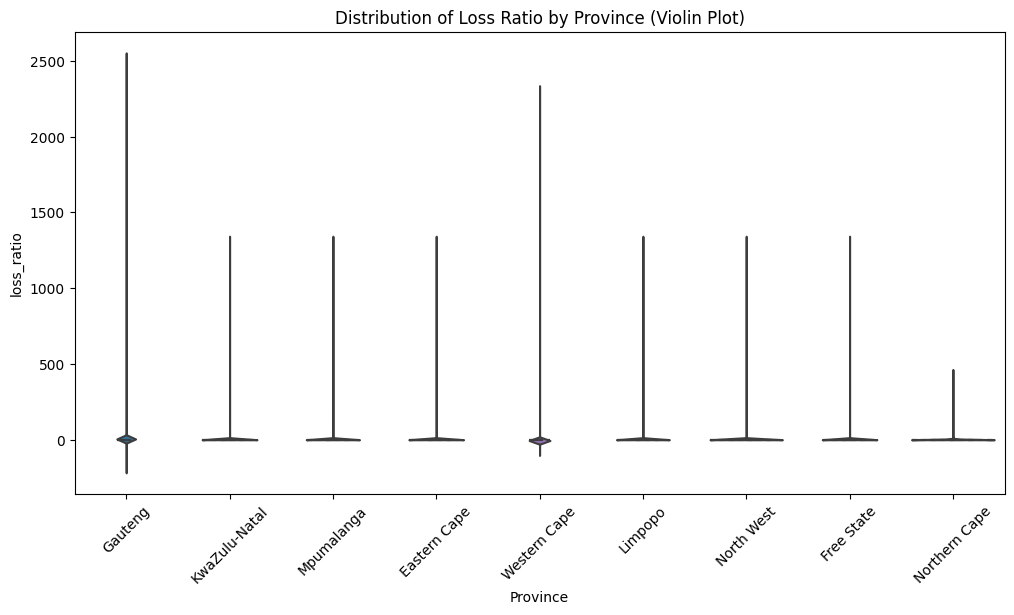

In [11]:
df["loss_ratio"] = df["TotalClaims"] / df["TotalPremium"].replace(0, np.nan)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.violinplot(data=df, x="Province", y="loss_ratio", inner="quartile", cut=0)
plt.xticks(rotation=45)
plt.title("Distribution of Loss Ratio by Province (Violin Plot)")
plt.show()


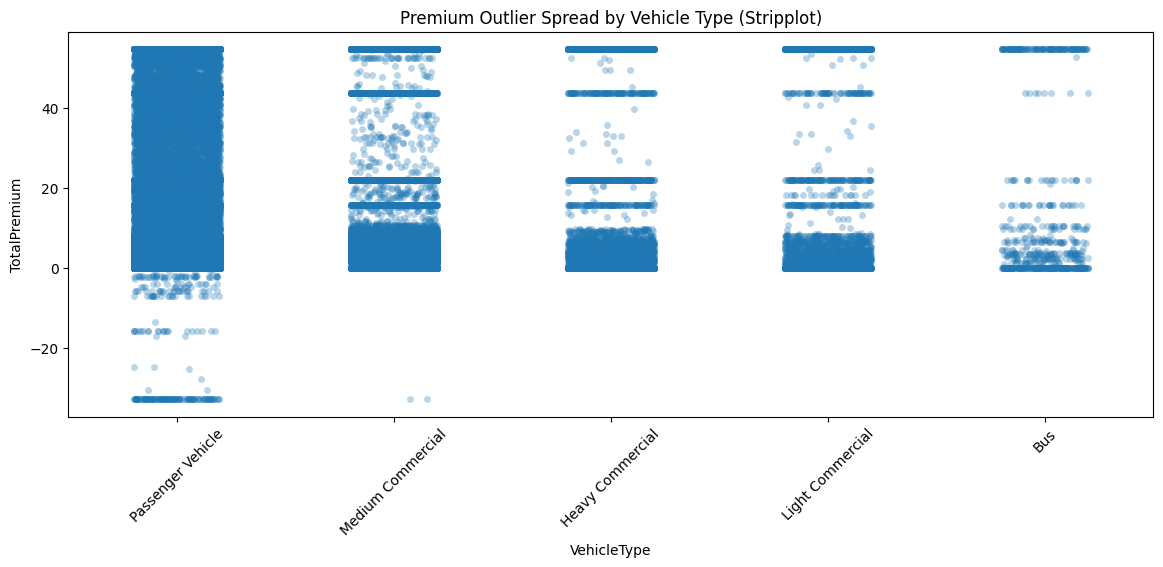

In [12]:
plt.figure(figsize=(14,5))
sns.stripplot(data=df, x="VehicleType", y="TotalPremium", alpha=0.3, jitter=0.2)
plt.xticks(rotation=45)
plt.title("Premium Outlier Spread by Vehicle Type (Stripplot)")
plt.show()


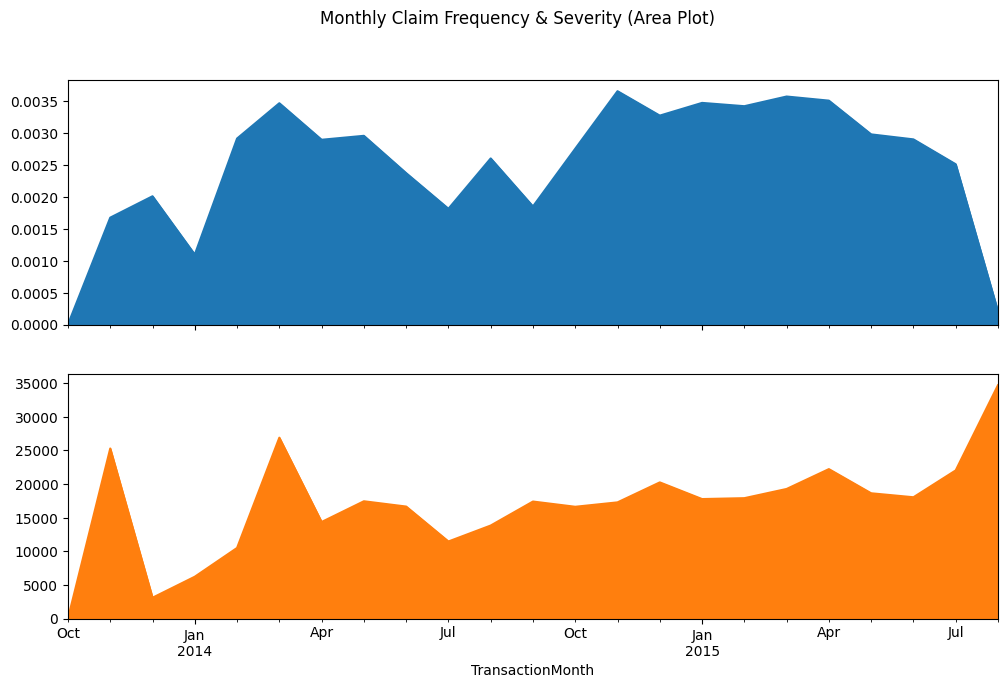

In [13]:
# Frequency and Severity Trends (Area)
df["has_claim"] = (df["TotalClaims"] > 0).astype(int)
monthly = df.groupby("TransactionMonth").agg(
    claim_freq = ("has_claim", "mean"),
    avg_claim  = ("TotalClaims", lambda x: x[x>0].mean() if any(x>0) else 0)
).reset_index()

monthly.set_index("TransactionMonth")[["claim_freq", "avg_claim"]].plot.area(subplots=True, layout=(2,1), figsize=(12,7), legend=False)
plt.suptitle("Monthly Claim Frequency & Severity (Area Plot)")
plt.show()


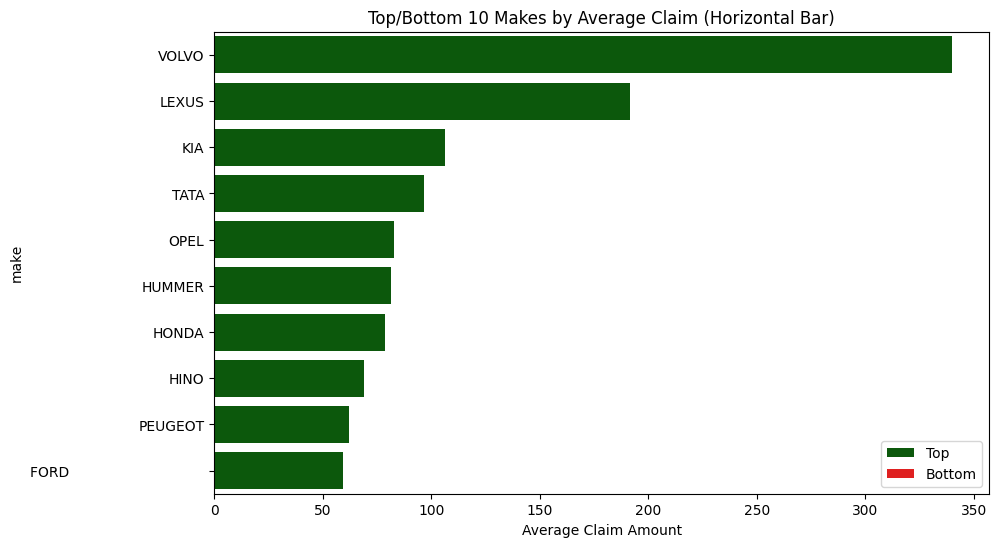

In [14]:
top_makes = (
    df.groupby("make")["TotalClaims"]
      .agg(["mean","count"])
      .query("count >= 100")
      .sort_values("mean", ascending=False)
      .head(10)
)

bottom_makes = (
    df.groupby("make")["TotalClaims"]
      .agg(["mean","count"])
      .query("count >= 100")
      .sort_values("mean", ascending=True)
      .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(y=top_makes.index, x=top_makes["mean"], color='darkgreen', label="Top")
sns.barplot(y=bottom_makes.index, x=bottom_makes["mean"], color='red', label="Bottom")
plt.legend()
plt.title("Top/Bottom 10 Makes by Average Claim (Horizontal Bar)")
plt.xlabel("Average Claim Amount")
plt.show()


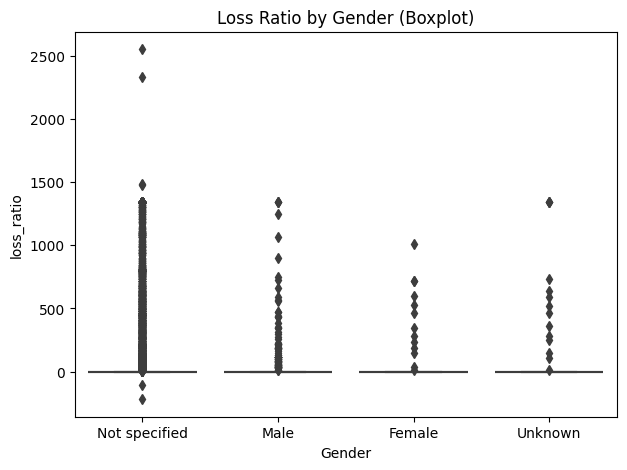

In [15]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="Gender", y="loss_ratio")
plt.title("Loss Ratio by Gender (Boxplot)")
plt.show()
